In [14]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, roc_auc_score

import statsmodels.api as sm

In [15]:
pd.set_option("display.max_rows",50)
df=pd.read_csv('Phishing_Legitimate_full.csv')

#koniecznie usuwamy id bo przypisuje do tej kolumny predykcje, anstenie model ma metryki 1
df.drop(['id'],axis=1,inplace=True)

In [16]:
#podział zmiennych w modelu na numeryczne i kateogryczne 
target = 'CLASS_LABEL'
numFeatures = ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'NumUnderscore','NumPercent', 'NumQueryComponents', 'NumAmpersand',
       'NumNumericChars','HostnameLength', 'PathLength', 'QueryLength',
       'NumSensitiveWords']
catFeatures = ['AtSymbol','TildeSymbol','NumHash', 'NoHttps','RandomString', 'IpAddress','DomainInSubdomains','DomainInPaths','HttpsInHostname',
              'DoubleSlashInPath','EmbeddedBrandName','PctExtHyperlinks','PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm','ExtMetaScriptLinkRT','UrlLengthRT','SubdomainLevelRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR',
       'PctExtNullSelfRedirectHyperlinksRT']

In [17]:
#one hot encoding (na wszelki wypadek)
dummLev = pd.get_dummies(df[catFeatures], drop_first=True)
df = pd.concat([df[numFeatures], dummLev, df[[target]]], axis=1)

In [18]:
#standaryzacja zmiennych numerycznych
df[numFeatures] = df[numFeatures].apply(lambda x: (x-x.mean())/x.std())

In [19]:
features = df.columns.tolist()
features.remove(target)
print(features)

['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumNumericChars', 'HostnameLength', 'PathLength', 'QueryLength', 'NumSensitiveWords', 'AtSymbol', 'TildeSymbol', 'NumHash', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname', 'DoubleSlashInPath', 'EmbeddedBrandName', 'PctExtHyperlinks', 'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms', 'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction', 'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch', 'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow', 'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle', 'ImagesOnlyInForm', 'ExtMetaScriptLinkRT', 'UrlLengthRT', 'SubdomainLevelRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'PctExtNullSelfRedirectHyperlinksRT']


In [20]:
#wrapper walidacji krzyżowej dla algorytmu SVM
def CVTestSVM(nFolds = 5, randomState=2020, debug=False, sampleSize = 5000, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    # Listy na wyniki:
    testResults = []
    trainResults = []
    predictions = []
    indices = []
    
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = SVC(probability=True, max_iter=-1, random_state=2020, tol=0.001, cache_size=500, *args, **kwargs)
        # Wyświetlenie wywołania funkcji
        if debug:
            print(clf)
        #Zmniejszenie zbioru treningowego
        sampleSize = sampleSize
        X = df.iloc[train].sample(sampleSize)
        # Trenowanie modelu
        clf.fit(X[features], X[target])

        # Przygotowanie prognoz dla zbioru traeningowego i testowego
        # UWAGA Sklearn zwracałbędzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie statystyka lda każdego foldu
        trainScore = roc_auc_score((df[target].iloc[train]==1), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1), preds)
        
        # Zapisanie wyników do list
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [21]:
# trenowanie modelu dla kernela liniowego i c=1
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="linear")
# wyświetlenie wyników dla zbioru treningowego i testowego
print(np.mean(trainResults), np.mean(testResults))

0.9842554395456908 0.9829745988937514


In [22]:
#pierwszy model SVM teraz będziemy szukać lepszego rozwiązania
resultM1 = {
    "name":"SVM Lin",
    "description":"Pierwszy prosty model SVM, z domyślnym C=1 i liniowym kernelem",
    "specification":'kernel="linear"',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [23]:
# SVM z kernelem wielomianowym, stopnia drugiego
trainResults, testResults, predictions, indices = CVTestSVM(debug=True, degree=2, kernel="poly")
print(np.mean(testResults))
print(np.mean(trainResults), np.mean(testResults))

SVC(cache_size=500, degree=2, kernel='poly', probability=True,
    random_state=2020)
Train AUC: 0.9929098902972532 Valid AUC: 0.9921577176778364
SVC(cache_size=500, degree=2, kernel='poly', probability=True,
    random_state=2020)
Train AUC: 0.9923420662298561 Valid AUC: 0.9908553093151341
SVC(cache_size=500, degree=2, kernel='poly', probability=True,
    random_state=2020)
Train AUC: 0.9929559643395696 Valid AUC: 0.9882090449326395
SVC(cache_size=500, degree=2, kernel='poly', probability=True,
    random_state=2020)
Train AUC: 0.9930183713844015 Valid AUC: 0.9909526141287421
SVC(cache_size=500, degree=2, kernel='poly', probability=True,
    random_state=2020)
Train AUC: 0.9930871141986158 Valid AUC: 0.9918787969699242
0.9908106966048553
0.9928626812899394 0.9908106966048553


In [24]:
#zapisanie modelu SVM z wykorzystaniem kernela wielomianowgo stopnia 2 i c=1
resultM2 = {
    "name":"SVM Poly 2",
    "description":"Pierwszy prosty model SVM, z domyślnym C=1 i kernelem wielomianowym stopnia 2",
    "specification":'degree=2,kernel="poly"',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

In [25]:
#trenowanie modelu SVM z użyciem kernela radialnego (rbf) i c = 1
trainResults, testResults, predictions, indices = CVTestSVM(debug=True, kernel="rbf",)
print(np.mean(trainResults), np.mean(testResults))

SVC(cache_size=500, probability=True, random_state=2020)
Train AUC: 0.9940496116116261 Valid AUC: 0.9946368069250493
SVC(cache_size=500, probability=True, random_state=2020)
Train AUC: 0.9948085708755067 Valid AUC: 0.9918441409225158
SVC(cache_size=500, probability=True, random_state=2020)
Train AUC: 0.9945229410223889 Valid AUC: 0.9914153046396759
SVC(cache_size=500, probability=True, random_state=2020)
Train AUC: 0.9943765813462415 Valid AUC: 0.9905210232808715
SVC(cache_size=500, probability=True, random_state=2020)
Train AUC: 0.9940109906421728 Valid AUC: 0.9921148028700718
0.9943537390995874 0.9921064157276369


In [26]:
#zapisanie modelu z kernelem radialnym i c =1, teraz porównamy wyniki dla zbudowanych modeli i pokażemy je za pomocą krzywych ROC
resultM3 = {
    "name":"SVM RBF",
    "description":"Pierwszy prosty model SVM, z domyślnym C=1 i kernelem RBF",
    "specification":'kernel="rbf",',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

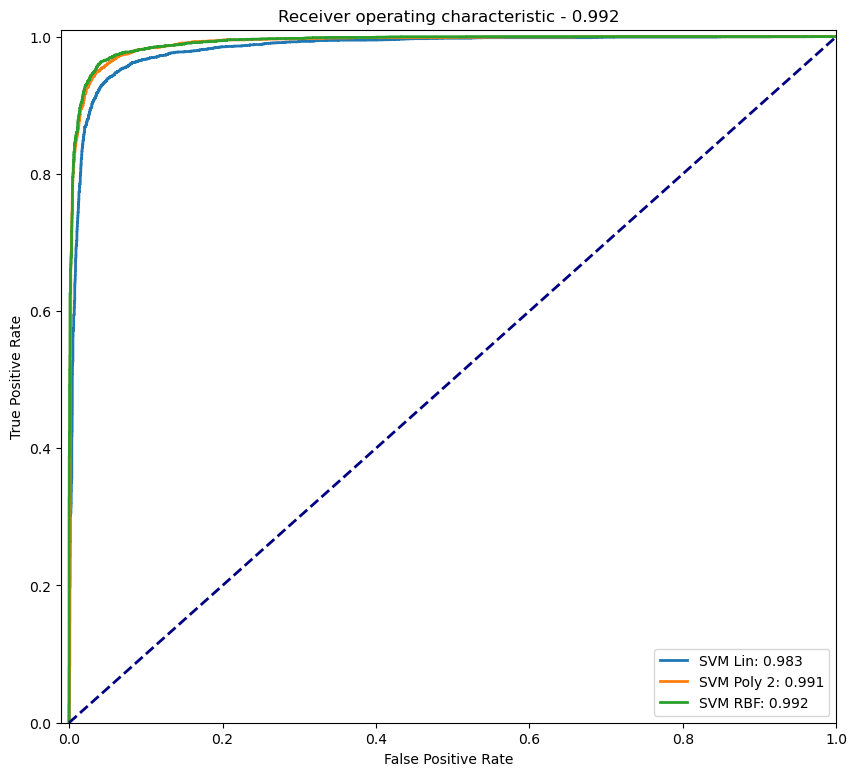

In [27]:
def plotROCs(results):
    ''' Funkcja, do rysowania szeregu wyników krzywych ROC dla poszczególnych eksperymentów
    results - lista wyników jako 3 elementowe tuple (true, pred, label)
    '''

    # Ustalanie wielkości rysunku
    fig, ax = plt.subplots(figsize=(10,9))

    for true, pred, label in results:
        # Obliczenie punktów potrzebnych do narysowani akrzywej ROC
        # funkcja roc_curve zwarca trzy serie danych, fpr, tpr oraz poziomy progów odcięcia
        fpr, tpr, thresholds = roc_curve(true, pred)
        # Obliczamy pole powierzchni pod krzywą
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)

        # Grubość krzywej
        lw = 2

        # Rysujemy krzywą ROC
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
    # Rysujemy krzywą 45 stopni jako punkt odniesienia
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    # Dodajemy lekkie marginesy do zakresu aby krzywa nie pokrywała się z osiami
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    plt.show()

res2plot = []
true = (df[target]==1).sort_index()
for result in [resultM1, resultM2, resultM3]:
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))

plotROCs(res2plot)

In [28]:
#ze względu na najlepsze wyniki modelu z kernelem radialnym teraz szukamy optymalnego c
testCvalue = []
for c in [0.01, 0.1, 0.25, 0.5, 1, 2, 5, 10, 25, 50, 100]:
    trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel="rbf", C=c)
    print(c, np.mean(testResults))
    testCvalue.append(
        {
        "name":f"SVM RBF = {c}",
        "description":"Testy z C i kernelem RBF",
        "specification":'kernel="rbf" C=c,',
        "trainResults":trainResults.copy(),
        "testResults":testResults.copy(),
        "predictions":predictions.copy(),
        "indices":indices.copy(),
    }
    )
#najlepszy model z użyciem SVM jest dla c=25 i kernela radialnego

0.01 0.9613370403560371
0.1 0.98508349152393
0.25 0.9891301438508787
0.5 0.9908946514738022
1 0.9921580208716139
2 0.9932540251948868
5 0.993928803211185
10 0.9939253357557527
25 0.9946655912232968
50 0.9944544076978261
100 0.9933842274765109


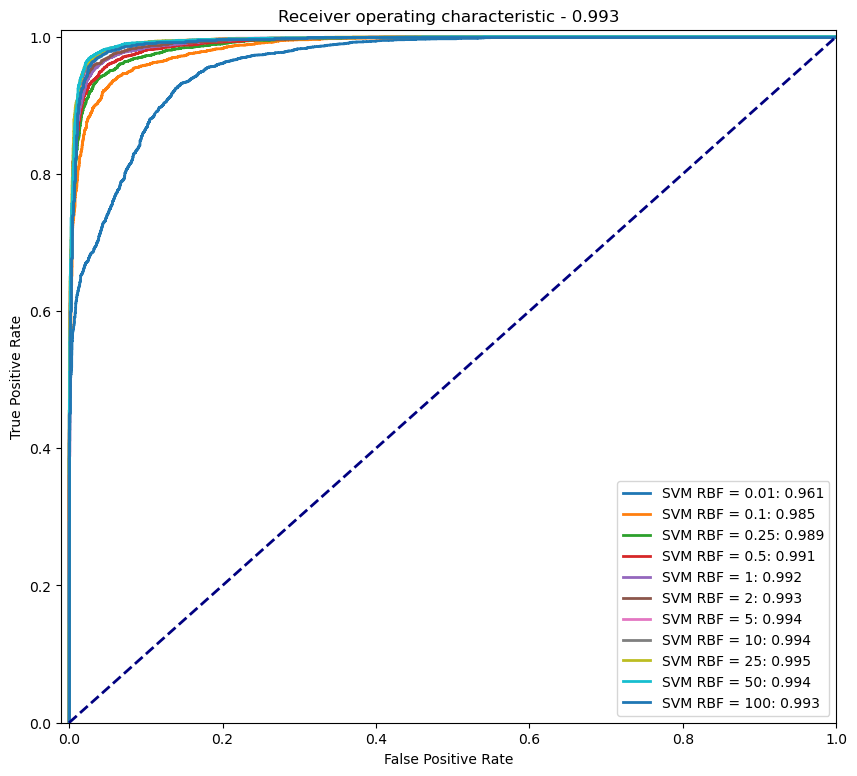

In [29]:
res2plot = []
true = (df[target]==1).sort_index()
for result in testCvalue:
    pred = pd.Series(sum(result["predictions"], []), index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
plotROCs(res2plot)